# Neural Network

Welcome to your next lab! You will solve problem of handwritten digits recognition using Neural Network.


**You will learn to:**
- Build the general architecture of a learning algorithm with OOP in mind:
    - Helper utilities
        - Sigmoid (and it's derivative)
        - One-Hot
        - Cost Function
        - Regularization
    - Neural Network Class
        - Forward propagation
        - Backward propagation
        - Upgrade parameters
    - Main Model Classes
        - Training
        - Prediction 

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seaborn](https://seaborn.pydata.org/) is a Python visualization library which provides a high-level interface for drawing attractive statistical graphics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

## 2 - Overview of the Problem set ##

**Problem Statement**: 
We'll use the MNIST data set, which contains tens of thousands of scanned images of handwritten digits, together with their correct classifications. MNIST's name comes from the fact that it is a modified subset of two data sets collected by NIST, the United States' National Institute of Standards and Technology.

The MNIST dataset contains 60,000 images. These images are scanned handwriting samples from 250 people, half of whom were US Census Bureau employees, and half of whom were high school students. The images are greyscale and 28 by 28 pixels in size. 
So, you are given a dataset  containing:
    - a training set of m_train examples labeld as 0-9
    - a test set of m_test examples labeld as 0-9
    - each example is an array of length 784 (28 * 28) which represents image of handwritten digit.
    
You will build an algorithm that can recognize handwritten digits.

Let's get more familiar with the dataset. Load the data by running the following code.

In [2]:
# Read the MNIST dataset from ubyte files 

def read_mnist(images_path, labels_path):
    import struct
    import os
    with open(labels_path, 'rb') as p:
        magic, n = struct.unpack('>II', p.read(8))
        labels = np.fromfile(p, dtype=np.uint8)
    with open(images_path, 'rb') as p:
        magic, num, rows, cols = struct.unpack(">IIII", p.read(16))
        images = np.fromfile(p, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

# Shuffle dataset

def shuffle_data(features, labels, random_seed=42):
    assert len(features) == len(labels)

    if random_seed:
        np.random.seed(random_seed)
    idx = np.random.permutation(len(features))
    return [a[idx] for a in [features, labels]] 

# Loading data

def load_data():     
    X, y = read_mnist('samples/train-images-idx3-ubyte', 'samples/train-labels-idx1-ubyte')
    X, y = shuffle_data(X, y, random_seed=42)
    train_set_x, train_set_y = X[:5000], y[:5000]
    test_set_x, test_set_y = X[5000:], y[5000:]
    
    test_set_x = test_set_x.reshape(test_set_x.shape[0], -1).T
    train_set_x = train_set_x.reshape(train_set_x.shape[0], -1).T
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x, test_set_x, train_set_y, test_set_y

Let's create train and test datasets:

In [3]:
train_set_x, test_set_x, train_set_y, test_set_y = load_data()
print('train set shapes: ', train_set_x.shape, train_set_y.shape)
print('test set shapes: ', test_set_x.shape, test_set_y.shape)

train set shapes:  (784, 5000) (1, 5000)
test set shapes:  (784, 55000) (1, 55000)


**Expected Output**: 

<table style="width:30%">
    <tr>
        <td><b>train set shapes:</b></td>
       <td> (784, 5000) <br>(1, 5000)</td>
    </tr>
    <tr>
        <td><b>test set shapes:</b></td>
       <td> (784, 55000)<br> (1, 55000)</td>
    </tr>
</table>

### Data exploration ###

Let's build a function to check how the data looks like:

In [4]:
def plot_digit(x_set, y_set, idx):
    img = x_set.T[idx].reshape(28,28)
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
    plt.title('true label: %d' % y_set.T[idx])
    plt.show()

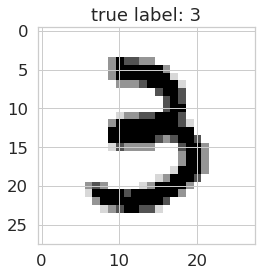

In [5]:
plot_digit(train_set_x, train_set_y, idx=1)

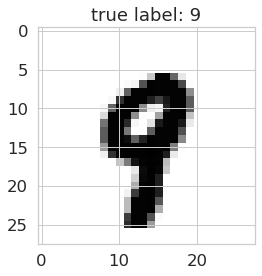

In [6]:
plot_digit(train_set_x, train_set_y, idx=3)

## 3 - Helper Functions

For begining we need to implement some special functions.

### Sigmoid (and it's derivative)

Any layer of a neural network can be considered as an Affine Transformation followed by application of a non linear function. A vector is received as input and is multiplied with a matrix to produce an output , to which a bias vector may be added before passing the result through an activation function such as sigmoid.

$$Input = x \quad Output = f(Wx+b)\tag{1}$$

The sigmoid function is used quite commonly in the realm of deep learning, at least it was until recently. It has distinct **S** shape and it is a differentiable real function for any real input value. Additionally, it has a positive derivative at each point. More importantly, we will use it as an activation function for the hidden layer of our model. Here's how it is defined:

$$\sigma (x) = \frac{1}{1+e^{-x}}\tag{2}$$

Here is first derivative (which we will use during the backpropagation step of our training algorithm). It has the following formula:

$$\frac{d\sigma (x)}{d(x)} = \sigma (x)\cdot (1-\sigma(x))\tag{3}$$

In [7]:
# GRADED CLASS: Sigmoid

class Sigmoid:
    def __call__(self, z):
        """
        Compute the sigmoid of z

        Arguments:
        z -- scalar or numpy array of any size.

        Return:
        sigmoid(z)
        """
        ### START CODE HERE ### (≈ 1 line of code)
        return 1/(1 + np.exp(-z))
        ### END CODE HERE ###
    
    def prime(self, z):
        """
        Compute the derivative of sigmoid of z

        Arguments:
        z -- scalar or numpy array of any size.

        Return:
        Sigmoid prime
        """
        ### START CODE HERE ### (≈ 1-2 lines of code)
        return Sigmoid()(z)*(1-Sigmoid()(z))
        ### END CODE HERE ###

In [8]:
x = np.linspace(-10., 10., num=100)
sig = Sigmoid()(x)
sig_prime = Sigmoid().prime(x)
print('sigmoid:')
print(sig[:5])
print('sigmoid_prime: ')
print(sig_prime[:5])

sigmoid:
[4.53978687e-05 5.55606489e-05 6.79983174e-05 8.32200197e-05
 1.01848815e-04]
sigmoid_prime: 
[4.53958077e-05 5.55575620e-05 6.79936937e-05 8.32130942e-05
 1.01838442e-04]


**Expected Output**: 

<table style="width:35%">
    <tr>
       <td><b>sigmoid:</b></td>
       <td> [  4.53978687e-05<br>   5.55606489e-05<br>   6.79983174e-05   8.32200197e-05<br>
   1.01848815e-04] </td>
    </tr>
    <tr>
        <td><b>sigmoid_prime:</b></td>
       <td> [  4.53958077e-05<br>   5.55575620e-05<br>   6.79936937e-05<br>   8.32130942e-05<br>
   1.01838442e-04] </td>
    </tr>

</table>

Now let's look at the picture:

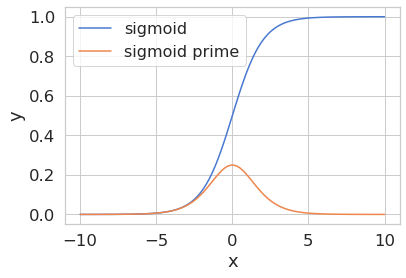

In [9]:
plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

The derivative shows the rate of change of a function. We can use it to determine the "slope" of that function. The highest rate of change for the sigmoid function is when $x=0$, as it is evident from the derivative graph.

### One-Hot ###

For convenience let's represent input labels $y$ as a 10-dimensional vector. For example, if a particular training image, $x$, depicts a 6, then $y(x)=(0,0,0,0,0,0,1,0,0,0)^T$ is the desired output from the network.

So, let's encode our labels as one-hot vectors:

In [10]:
# GRADED FUNCTION: one_hot

def one_hot(Y, n_classes):
    """
    Encode labels into a one-hot representation

    Arguments:
    Y -- array of input labels of shape (1, n_samples)
    n_classes -- number of classes

    Returns:
    onehot, a matrix of labels by samples. For each column, the ith index will be 
        "hot", or 1, to represent that index being the label; shape - (n_classes, n_samples)
    """
    ### START CODE HERE ### (≈ 1-4 lines of code)
    p = np.zeros((n_classes, len(Y[0])))
    for i in range(len(Y[0])):
        p[Y[0][i]][i] = 1
    return p
    ### END CODE HERE ###

In [11]:
print('encoded:')
print(one_hot(np.asarray([1, 2, 3, 4, 3]).reshape(1, 5), 5))

encoded:
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
        <td><b>encoded:</b></td>
        <td> [[ 0.  0.  0.  0.  0.]<br>
 [ 1.  0.  0.  0.  0.]<br>
 [ 0.  1.  0.  0.  0.]<br>
 [ 0.  0.  1.  0.  1.]<br>
 [ 0.  0.  0.  1.  0.]]</td>
    </tr>
    

### Cost Function ###

Here is cost function for our model:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \sum\limits_{j = 0}^{n}\large{(} \small y^{(i)}_{j}\log\left(a^{[2] (i)}_{j}\right) + (1-y^{(i)}_{j})\log\left(1- a^{[2] (i)}_{j}\right)  \small\large{)}\tag{4}$$
where 

$m$ - number of examples;

$n$ - number of classes;

$y$ - input labels;

$a$ - output of hidden layer.


We will use cross entropy loss:
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})\tag{5}$

In [12]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (4)
    
    Arguments:
    A2 -- sigmoid output of the hidden layer activation, of shape (classes, n_examples)
    Y -- labels of shape (classes, n_examples)
    
    Returns:
    cost -- cross-entropy cost given equation (4)
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    ### START CODE HERE ###
    cost = -(((Y*np.log(A2))+(1-Y)*np.log(1-A2))).sum()/m
    ### END CODE HERE ###
    
    return cost

In [13]:
np.random.seed(1)
labels = (np.random.randn(2, 3) > 0)
a_h = (np.array([[ 0.5 ,  0.49,  0.5], [0.1 ,  0.2,  0.3]]))
print("cost:" + str(compute_cost(a_h, labels)))

cost:1.3770374288047718


**Expected Output**: 

<table style="width:25%">
    <tr>
       <td><b>cost:</b></td>
       <td> 1.3770374288... </td>
    </tr>
    

</table>

### Regularization

In order to create less complex (parsimonious) model when you have a large number of features in your dataset, some of the Regularization techniques used to address over-fitting and feature selection are:

1. L1 Regularization

2. L2 Regularization

A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the cost function.

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. 
The cost is then computed by summing squared diff over all training examples.
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \sum\limits_{j = 0}^{n}\large{(} \small y^{(i)}_{j}\log\left(a^{[2] (i)}_{j}\right) + (1-y^{(i)}_{j})\log\left(1- a^{[2] (i)}_{j}\right)  \small\large{)}+$$<br>$$+\frac{\lambda_1}{m}( ||w_1||_1 + ||w_2||_1) + \frac{\lambda_2}{2m} (||w_1||_2^2+||w_2||_2^2) \tag{6}$$

To calculate norms use "entrywise" norm.

In [14]:
# GRADED CLASS: Regularisation

class Regularization:
    """ 
    Regularization class

    Arguments:
    lambda_1 -- regularization coeficient for l1 regularization
    lambda_2 -- regularization coeficient for l2 regularization
    """
    def __init__(self, lambda_1, lambda_2):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        
    def l1(self, W1, W2, m):
        """ 
        Compute l1 regularization part

        Arguments:
        W1 -- weigts of shape (n_hidden_units, n_features) 
        W2 -- weigts of shape (output_size, n_hidden_units) 
        m -- n_examples

        Returns:
        l1_term -- float, check formula (6)
        """
        ### START CODE HERE ###
        return (self.lambda_1/m)*((np.absolute(W1) + np.absolute(W2)).sum())
        ### END CODE HERE ###
        
    def l1_grad(self, W1, W2, m):
        """ 
        Compute l1 regularization term

        Arguments:
        W1 -- weigts of shape (n_hidden_units, n_features) 
        W2 -- weigts of shape (output_size, n_hidden_units) 
        m -- n_examples

        Returns:
         dict with l1_grads "dW1" and "dW2"
            which are grads by corresponding weights
        """
        ### START CODE HERE ###
        return {
            'dW1':(self.lambda_1/m)*np.sign(W1),
            'dW2':(self.lambda_1/m)*np.sign(W2)
                }
        ### END CODE HERE ###

    def l2(self, W1, W2, m):
        """ 
        Compute l2 regularization term

        Arguments:
        W1 -- weigts of shape (n_hidden_units, n_features) 
        W2 -- weigts of shape (output_size, n_hidden_units) 
        m -- n_examples

        Returns:
        l2_term: float, check formula (6)
        """
        ### START CODE HERE ###
        return self.lambda_2*(np.sqrt((np.absolute(W1)**2).sum())**2 + np.sqrt((np.absolute(W2)**2).sum())**2)/(2*m)
        ### END CODE HERE ###
        
    def l2_grad(self, W1, W2, m):
        """ 
        Compute l2 regularization term

        Arguments:
        W1 -- weigts of shape (n_hidden_units, n_features) 
        W2 -- weigts of shape (output_size, n_hidden_units) 
        m -- n_examples

        Returns:
        l2_grads: dict with keys "dW1" and "dW2"
        """
        ### START CODE HERE ###
        L = self.l2(W1, W2, m)
        return {'dW1':(self.lambda_2/m)*W1, 'dW2':(self.lambda_2/m)*W2}
        ### END CODE HERE ###

In [15]:
reg = Regularization(0.3, 0.2)
print('l1 reg. term =', reg.l1(np.array([0.1, -0.2, 0.3, 0.4]), np.array([-0.5, 0.6, 0.7, 0.8]), 5))
print('l2 reg. term =', reg.l2(np.array([0.1, -0.2, 0.3, 0.4]), np.array([-0.5, 0.6, 0.7, 0.8]), 5))
print('l1 reg. gradient =', reg.l1_grad(np.array([0.1, -0.2, 0.3, 0.4]), np.array([-0.5, 0.6, 0.7, 0.8]), 5))
print('l2 reg. gradient =', reg.l2_grad(np.array([0.1, -0.2, 0.3, 0.4]), np.array([-0.5, 0.6, 0.7, 0.8]), 5))

l1 reg. term = 0.216
l2 reg. term = 0.0408
l1 reg. gradient = {'dW1': array([ 0.06, -0.06,  0.06,  0.06]), 'dW2': array([-0.06,  0.06,  0.06,  0.06])}
l2 reg. gradient = {'dW1': array([ 0.004, -0.008,  0.012,  0.016]), 'dW2': array([-0.02 ,  0.024,  0.028,  0.032])}


**Expected Output**: 

<table style="width:80%">
    <tr>
        <td><b>l1 reg. term</b></td>
       <td> 0.216 </td>
    </tr>
    <tr>
        <td><b>l2 reg. term</b></td>
       <td>  0.0408 </td>
    </tr>
    <tr>
        <td><b>l1 reg. gradient</b></td>
       <td> {'dW1': array([ 0.06, -0.06,  0.06,  0.06]), </td>
       <td>  'dW2': array([-0.06,  0.06,  0.06,  0.06])} </td>
    </tr>
    <tr>
        <td><b>l2 reg. gradient</b></td>
       <td> {'dW1': array([ 0.004, -0.008,  0.012,  0.016]),
  </td>
      <td> 'dW2': array([-0.02 ,  0.024,  0.028,  0.032])}
      </td>
    </tr>


</table>

## 3 - Neural Network. General Architecture ##

To recognize digits we will use a two-layer neural network. Here is model of our network:
    <img src="samples/arc.png" style="width:620px;height:500px;">
    
The input layer of the network contains neurons encoding the values of the input pixels. As discussed earlier, training data consist of many 28 by 28 pixel images of scanned handwritten digits, and so the input layer contains $784=28×28$ neurons. The input pixels are greyscale, with a value of 0.0 representing white, a value of 1.0 representing black, and in between values representing gradually darkening shades of grey.

The first layer of the network is a hidden layer. We denote the number of neurons in this hidden layer by n, and we'll experiment with different values for n. The example shown illustrates a small hidden layer, containing just $n=15$ neurons.

The output layer of the network contains 10 neurons. If the first neuron fires, i.e., has an output $≈1$, then that will indicate that the network thinks the digit is a 0. If the second neuron fires then that will indicate that the network thinks the digit is a 1, and so on. A little more precisely, we number the output neurons from 0 through 9, and figure out which neuron has the highest activation value. If that neuron is, say, neuron number 6, then our network will guess that the input digit was a 6. And so on for the other output neurons.

Each training input $x$ is a $28×28=784$-dimensional vector. Each entry in the vector represents the grey value for a single pixel in the image. 


### 3.1 - Neural Network Class ####

In this block we will implement class *NeuralNetwork*, which will perform forward and backward propagation, and update parameters.  

**Main steps to build neural network:**
    1. Initialize the model's parameters
    2. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)
        
**1. Initializing the model's parameters**

You need to do following steps:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.        
- Initialize the weights matrices with random values from the “standard normal” distribution, where sigma = 0.01, mu = 0. 
- Initialize the bias vectors as zeros. 
   
**2. Loop**

   - *Forward propagation*
   
In forward propagation we use the data and the weights of the network to compute a prediction, so during this step we just multiply the matrix containing our training data with the matrix of the weights of the hidden layer.

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{8}$$ 
$$a^{[1] (i)} = \sigma(z^{[1] (i)})\tag{9}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{10}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{11}$$
$$y^{(i)}_{prediction} = argmax(a^{[2](i)}) \tag{12}$$

Definition: 

$W^{[1]}$: weights matrix 1

$W^{[2]}$: weights matrix 2

$b^{[1]}$: bias 1

$b^{[2]}$: bias 2

$z^{[1] (i)}$ : input of the hidden layer

$a^{[1] (i)}$: activation of the hidden layer

$z^{[2] (i)}$: input of the output layer 

$a^{[2] (i)}$: activation of the output layer

$\hat{y}^{(i)}$: array of predictions

   - *Backward propagation*
   
In backpropagation step we apply the activation function (sigmoid) to the result and multiply that with the weight matrix of the output layer. 

<table style="width:90%">
    <tr>
       <td> $dz^{[2]} = a^{[2]} - y$  </td>
       <td> $dZ^{[2]} = A^{[2]} - Y$ </td>
    </tr>
    <tr>
       <td> $dW^{[2]} = dz^{[2]}a^{[1]T} + \frac{\lambda_1}{m}sign(W^{[2]}) + \frac{\lambda_2}{m}W^{[2]}$ </td>
       <td>  $dW^{[2]} = \frac{1}{m}dZ^{[2]}A^{[1]T} + \frac{\lambda_1}{m}sign(W^{[2]}) + \frac{\lambda_2}{m}W^{[2]}$ </td>
    </tr>
    <tr>
       <td> $db^{[2]} = dz^{[2]}$ </td>
       <td> $db^{[2]} = \frac{1}{m}np.sum(dZ^{[2]}, axis=1, keepdims=True)$ </td>
    </tr>
    <tr>
       <td> $dz^{[1]} = W^{[2]T}dz^{[2]}*\sigma'(z^{[1]})$ </td>
       <td> $dz^{[1]} = W^{[2]T}dZ^{[2]}*\sigma'(Z^{[1]})$ </td>
    </tr>
    <tr>
       <td> $dW^{[1]} = dz^{[1]}x^T + \frac{\lambda_1}{m}sign(W^{[1]}) + \frac{\lambda_2}{m}W^{[1]}$ </td>
       <td> $dW^{[1]} = \frac{1}{m}dZ^{[1]}X^T + \frac{\lambda_1}{m}sign(W^{[1]}) + \frac{\lambda_2}{m}W^{[1]}$  </td>
    </tr>
    <tr>
       <td> $db^{[1]} = dZ^{[1]}$ </td>
       <td> $db^{[1]} = \frac{1}{m}np.sum(dZ^{[1]}, axis=1, keepdims=True)$  </td>
    </tr>
</table>

   - *Update Parameters*
   
Next, the error is computed based on the prediction and the provided labels. The final step propagates the error through the network, starting from the final layer. Thus, the weights get updated based on the error, little by little. To implement this method we will use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="samples/sgd.gif" style="width:400;height:400;"> <img src="samples/sgd_bad.gif" style="width:400;height:400;">


Implement class `NeuralNetwork` in the cell below: 

In [16]:
# GRADED CLASS NeuralNetwork

class NeuralNetwork:
    """
    Arguments:
    n_features: int -- Number of features
    n_hidden_units: int -- Number of hidden units
    n_classes: int -- Number of classes
    learning_rate: float
    reg: instance of Regularization class
    """
    def __init__(self, n_features, n_hidden_units, n_classes , learning_rate, reg=Regularization(0.1, 0.2), sigm=Sigmoid()):
        self.n_features = n_features
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.n_hidden_units = n_hidden_units
        self.reg = reg
        self.sigm = sigm
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        W1 -- weight matrix of shape (self.n_hidden_units, self.n_features)
        b1 -- bias vector of shape (self.n_hidden_units, 1)
        W2 -- weight matrix of shape (self.n_classes, self.n_hidden_units)
        b2 -- bias vector of shape (self.n_classes, 1)
        """
        np.random.seed(42) 
    
        ### START CODE HERE ###
        self.W1 = np.random.normal(0, 0.01, (self.n_hidden_units, self.n_features))
        self.b1 = np.zeros((self.n_hidden_units, 1))
        self.W2 = np.random.normal(0, 0.01, (self.n_classes, self.n_hidden_units))
        self.b2 = np.zeros((self.n_classes, 1))
        ### END CODE HERE ###

    def forward_propagation(self, X):
        """
        Arguments:
        X -- input data of shape (number of features, number of examples)
        
        Returns:
        dictionary containing "Z1", "A1", "Z2" and "A2"
        """
        # Implement Forward Propagation to calculate A2 (probabilities)
        ### START CODE HERE ### 

        ### END CODE HERE ###
        Z1 = self.W1@X+self.b1
        A1 = self.sigm(Z1)
        Z2 = self.W2@A1+self.b2
        A2 = self.sigm(Z2)
        return {
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }
    
    def backward_propagation(self, X, Y, cache):
        """
        Arguments:
        X -- input data of shape (number of features, number of examples)
        Y -- one-hot encoded vector of labels with shape (n_classes, n_samples)
        cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"

        Returns:
        dictionary containing gradients "dW1", "db1", "dW2", "db2"
        """
        m = X.shape[1]
        
        # Retrieve also A1 and A2 from dictionary "cache".
        ### START CODE HERE ### 
        A1, A2, Z1, Z2 = cache['A1'], cache['A2'], cache['Z1'], cache['Z2']
        ### END CODE HERE ###

        # Backward propagation: calculate dW1, db1, dW2, db2. 
        ### START CODE HERE ###
        dZ2 = A2 - Y
        dW2 = ((dZ2@A1.T) + self.reg.lambda_1*np.sign(self.W2) + self.reg.lambda_2*self.W2)/m
        db2 = np.sum(dZ2, axis=1,keepdims=True)/m
        
        dZ1 = (self.W2.T@dZ2)*self.sigm.prime(Z1)
        dW1 = ((dZ1@X.T) + self.reg.lambda_1*np.sign(self.W1) + self.reg.lambda_2*self.W1)/m
        db1 = np.sum(dZ1, axis=1,keepdims=True)/m
        ### END CODE HERE ###

        return {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }

    def update_parameters(self, grads):
        """
        Updates parameters using the gradient descent update rule 

        Arguments:
        grads -- python dictionary containing gradients "dW1", "db1", "dW2", "db2"
        """
        # Retrieve each gradient from the dictionary "grads"

        ### START CODE HERE ### 
        dW1, db1, dW2, db2 = grads['dW1'], grads['db1'], grads['dW2'], grads['db2']
        ## END CODE HERE ###

        # Update each paramet
        ### START CODE HERE ### 
        self.W1 = self.W1 - self.learning_rate*dW1
        self.b1 = self.b1 - self.learning_rate*db1
        self.W2 = self.W2 - self.learning_rate*dW2
        self.b2 = self.b2 - self.learning_rate*db2
        ### END CODE HERE ###

Init Neural Network class:

In [17]:
nn_test = NeuralNetwork(2, 4, 3, 0.01)
x_test = np.asarray([[1, 2, 1, 1], [2, 1, 2, 1]])
y_test = np.asarray([1, 2, 1, 0]).reshape(1, 4)

Initialize parameters test:

In [18]:
print('W1:', nn_test.W1)
print('b1:', nn_test.b1)
print('W2:', nn_test.W2)
print('b2:', nn_test.b2)

W1: [[ 0.00496714 -0.00138264]
 [ 0.00647689  0.0152303 ]
 [-0.00234153 -0.00234137]
 [ 0.01579213  0.00767435]]
b1: [[0.]
 [0.]
 [0.]
 [0.]]
W2: [[-0.00469474  0.0054256  -0.00463418 -0.0046573 ]
 [ 0.00241962 -0.0191328  -0.01724918 -0.00562288]
 [-0.01012831  0.00314247 -0.00908024 -0.01412304]]
b2: [[0.]
 [0.]
 [0.]]


**Expected Output**: 

<table style="width:65%">
    <tr>
       <td style="width:15%"><b>W1</b></td>
       <td> [[ 0.00496714 -0.00138264]<br>
 [ 0.00647689  0.0152303 ]<br>
 [-0.00234153 -0.00234137]<br>
 [ 0.01579213  0.00767435]] </td>
    </tr>
    <tr>
        <td><b>b1</b></td>
       <td> [[ 0.]<br>
 [ 0.]<br>
 [ 0.]<br>
 [ 0.]] </td>
    </tr>
    <tr>
        <td><b>W2</b></td>
       <td> [[-0.00469474  0.0054256  -0.00463418 -0.0046573 ]<br>
 [ 0.00241962 -0.0191328  -0.01724918 -0.00562288]<br>
 [-0.01012831  0.00314247 -0.00908024 -0.01412304]] </td>
    </tr>
    <tr>
        <td><b>b2</b></td>
       <td> [[0.]<br>
 [0.]<br>
 [0.]] </td>
</table>

Forward method test:

In [19]:
cache = nn_test.forward_propagation(x_test)
print('Z1:',cache['Z1'])
print('A1:',cache['A1'])
print('Z2:',cache['Z2'])
print('A2:',cache['A2'])

Z1: [[ 0.00220186  0.00855164  0.00220186  0.0035845 ]
 [ 0.03693748  0.02818407  0.03693748  0.02170718]
 [-0.00702427 -0.00702444 -0.00702427 -0.0046829 ]
 [ 0.03114082  0.0392586   0.03114082  0.02346648]]
A1: [[0.50055046 0.5021379  0.50055046 0.50089612]
 [0.50923332 0.50704555 0.50923332 0.50542658]
 [0.49824394 0.4982439  0.49824394 0.49882928]
 [0.50778458 0.50981339 0.50778458 0.50586635]]
Z2: [[-0.00426091 -0.00428969 -0.00426091 -0.00427697]
 [-0.01998143 -0.01994713 -0.01998143 -0.01990707]
 [-0.01516511 -0.01521672 -0.01516511 -0.0151588 ]]
A2: [[0.49893477 0.49892758 0.49893477 0.49893076]
 [0.49500481 0.49501338 0.49500481 0.4950234 ]
 [0.49620879 0.49619589 0.49620879 0.49621037]]


**Expected Output**: 

<table style="width:70%">
    <tr>
        <td style="width:15%"><b>Z1</b></td>
       <td> [[ 0.00220186  0.00855164  0.00220186  0.0035845 ]<br>
 [ 0.03693748  0.02818407  0.03693748  0.02170718]<br>
 [-0.00702427 -0.00702444 -0.00702427 -0.0046829 ]<br>
 [ 0.03114082  0.0392586   0.03114082  0.02346648]] </td>
    </tr>
    <tr>
        <td><b>A1</b></td>
       <td> [[0.50055046 0.5021379  0.50055046 0.50089612]<br>
 [0.50923332 0.50704555 0.50923332 0.50542658]<br>
 [0.49824394 0.4982439  0.49824394 0.49882928]<br>
 [0.50778458 0.50981339 0.50778458 0.50586635]] </td>
    </tr>
    <tr>
        <td><b>Z2</b></td>
       <td> [[-0.00426091 -0.00428969 -0.00426091 -0.00427697]<br>
 [-0.01998143 -0.01994713 -0.01998143 -0.01990707]<br>
 [-0.01516511 -0.01521672 -0.01516511 -0.0151588 ]] </td>
    </tr>
    <tr>
        <td><b>A2</b></td>
       <td> [[0.49893477 0.49892758 0.49893477 0.49893076]<br>
 [0.49500481 0.49501338 0.49500481 0.4950234 ]<br>
 [0.49620879 0.49619589 0.49620879 0.49621037]]</td>
</table>

Backward method test:

In [20]:
grads = nn_test.backward_propagation(x_test, y_test, cache)
print ("dW1: "+ str(grads["dW1"]))
print ("db1: "+ str(grads["db1"]))
print ("dW2: "+ str(grads["dW2"]))
print ("db2: "+ str(grads["db2"]))

dW1: [[ 0.02797138 -0.02273175]
 [ 0.02765858  0.02777095]
 [-0.01830467 -0.01926442]
 [ 0.03115285  0.02999027]]
db1: [[0.00155825]
 [0.00133963]
 [0.00390176]
 [0.0030709 ]]
dW2: [[-0.27659717 -0.22954308 -0.27481279 -0.2806681 ]
 [-0.22820569 -0.28276153 -0.27739741 -0.28270719]
 [-0.27823467 -0.23104133 -0.27639371 -0.28252569]]
db2: [[-0.50106803]
 [-0.5049884 ]
 [-0.50379404]]


**Expected Output**: 

<table style="width:65%">
    <tr>
        <td style="width:15%"><b>dW1</b></td>
       <td> [[ 0.02797138 -0.02273175]<br>
 [ 0.02765858  0.02777095]<br>
 [-0.01830467 -0.01926442]<br>
 [ 0.03115285  0.02999027]] </td>
    </tr>
    <tr>
        <td><b>db1</b></td>
       <td> [[0.00155825]<br>
 [0.00133963]<br>
 [0.00390176]<br>
 [0.0030709 ]]</td>
    </tr>
    <tr>
        <td><b>dW2</b></td>
       <td> [[-0.27659717 -0.22954308 -0.27481279 -0.2806681 ]<br>
 [-0.22820569 -0.28276153 -0.27739741 -0.28270719]<br>
 [-0.27823467 -0.23104133 -0.27639371 -0.28252569]]<br>
 </td>
    </tr>
    <tr>
        <td><b>db2</b></td>
       <td> [[-0.50106803]<br>
 [-0.5049884 ]<br>
 [-0.50379404]] </td>
    </tr>
</table>

Update parameters test:

In [21]:
nn_test.update_parameters(grads)
print('W1:', nn_test.W1)
print('b1:', nn_test.b1)
print('W2:', nn_test.W2)
print('b2:', nn_test.b2)

W1: [[ 0.00468743 -0.00115533]
 [ 0.0062003   0.01495259]
 [-0.00215849 -0.00214873]
 [ 0.0154806   0.00737444]]
b1: [[-1.55825086e-05]
 [-1.33963447e-05]
 [-3.90175629e-05]
 [-3.07090141e-05]]
W2: [[-0.00192877  0.00772103 -0.00188605 -0.00185062]
 [ 0.00470168 -0.01630519 -0.0144752  -0.0027958 ]
 [-0.00734596  0.00545289 -0.0063163  -0.01129778]]
b2: [[0.00501068]
 [0.00504988]
 [0.00503794]]


**Expected Output**: 

<table style="width:60%">
    <tr>
        <td style="width:15%"><b>W1</b></td>
       <td> [[ 0.00468743 -0.00115533]<br>
 [ 0.0062003   0.01495259]<br>
 [-0.00215849 -0.00214873]<br>
 [ 0.0154806   0.00737444]]</td>
    </tr>
    <tr>
        <td><b>b1</b></td>
       <td> [[-1.55825086e-05]<br>
 [-1.33963447e-05]<br>
 [-3.90175629e-05]<br>
 [-3.07090141e-05]]</td>
    </tr>
    <tr>
       <td><b>W2</b></td>
       <td> [[-0.00192877  0.00772103 -0.00188605 -0.00185062]<br>
 [ 0.00470168 -0.01630519 -0.0144752  -0.0027958 ]<br>
 [-0.00734596  0.00545289 -0.0063163  -0.01129778]] </td>
    </tr>
    <tr>
       <td><b>db2</b></td>
       <td> [[0.00501068]<br>
 [0.00504988]<br>
 [0.00503794]] </td>
    </tr>
</table>

### 3.2 - Model ####

Now we can aggregate all previous modules into a classifier:

In [22]:
# GRADED CLASS NNClassifier

class NNClassifier:
    """
    NNClassifier class
    
    Arguments:
    model -- instance of NN
    epochs: int -- Number of epochs
    """
    def __init__(self, model, epochs=1000):
        self.model = model
        self.epochs = epochs
        self._cost = [] # Write value of cost function after each epoch to build graph later
    
    def fit(self, X, Y):
        """
        Learn weights and errors from training data

        Arguments:
        X -- input data of shape (number of features, number of examples)
        Y -- labels of shape (1, number of examples)
        """
    
        ### START CODE HERE ###
        Y = one_hot(Y, self.model.n_classes)
        for i in range(self.epochs):
            cache = self.model.forward_propagation(X)
            self._cost.append(compute_cost(cache['A2'], Y))
            #grads = 
            self.model.update_parameters(self.model.backward_propagation(X, Y, cache))
            print(self._cost[i])
        ### END CODE HERE ###
    
    def predict(self, X):
        """
        Generate array of predicted labels for the input dataset
        
        Arguments:
        X -- input data of shape (number of features, number of examples)
        
        Returns:
        predicted labels of shape (1, n_samples)
        """
        
        ### START CODE HERE ### (≈ 2 lines of code)
        cache = self.model.forward_propagation(X)
        ### END CODE HERE ###

        return np.argmax(cache['A2'], axis=0).T

Accuracy:

In [23]:
def accuracy(pred, labels):
    return (np.sum(pred == labels, axis=1) / float(labels.shape[1]))[0]

Function for visualizing an error change:

In [24]:
def plot_error(model, epochs):
    plt.plot(range(len(model._cost)), model._cost)
    plt.ylim([0, epochs])
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()

## 4 - Training 

Let's initialize our classifier:

In [25]:
NN = NeuralNetwork(784, 30, 10, 0.01)
classifier = NNClassifier(NN, 5000)

After last iteration value of cost function must be <1.8:

In [26]:
classifier.fit(train_set_x, train_set_y)

6.855245690775138
6.658113531637758
6.441298680418771
6.1989571968825254
5.943782095034
5.692884937649533
5.452208088158559
5.226505546886349
5.019318976082951
4.832264336804625
4.667158272711388
4.523336746954219
4.397210867111729
4.286276056346315
4.188282219156204
4.101331605366625
4.024002567270387
3.955126235887299
3.893559634342628
3.8383803819660547
3.7888187897386416
3.7442012687234802
3.70393568404376
3.6675159582216295
3.6345066138332025
3.6045338317839066
3.577273880300695
3.552441815534196
3.5297851693909377
3.5090804139876695
3.4901299502445844
3.472759540752956
3.456815492730046
3.4421618394188167
3.428677755336261
3.4162554814546384
3.4047987380996005
3.3942213692607446
3.3844460703759496
3.3754032343394633
3.3670300903536337
3.359270150203268
3.3520724458705424
3.3453906396017343
3.3391825800256645
3.3334098863787847
3.3280377057899737
3.323034165884422
3.3183695468070917
3.3140173484759305
3.3099553858092796
3.3061620717710385
3.302617061825202
3.299302246500455
3.2962

3.160664587109991
3.1605396596380557
3.1603090231518283
3.1598119246175935
3.1592404678921673
3.1586801050758355
3.158105776500403
3.157620086519085
3.157292671786212
3.1568821169972976
3.156581036958692
3.1562072129164376
3.155942439716172
3.1556679775967282
3.155556420428289
3.155538722570289
3.155430386104818
3.155289397541638
3.15520107398103
3.1546457195423456
3.154212298145825
3.153543948906469
3.1529351633402443
3.1524029033786674
3.1520794921566666
3.1516437511664854
3.151335858706274
3.1509405847429983
3.1506572905368357
3.1503191827242665
3.1501421435777845
3.149991475068115
3.150057636182075
3.1499235805699586
3.15009426541007
3.1495039784206442
3.149454114613024
3.1484596226085144
3.1479368270013417
3.147177360454778
3.1468925116076334
3.146348354044286
3.1460662988211117
3.1456013497021917
3.14532101296587
3.144932706999385
3.144746540301388
3.1445407935066245
3.144700205329655
3.1443239344179625
3.1445931119467194
3.144008617834125
3.1443806136378627
3.1432191821120754
3.

2.9568674030689652
2.9473649995776645
2.9509395031846513
2.9497986209069067
2.942438806145359
2.944202369607322
2.940827052630131
2.939459732274655
2.9429046888475168
2.940201822202154
2.9450298045393697
2.936509275200499
2.935134022110131
2.936519739622361
2.936780760078244
2.9429451972150535
2.9359997562417233
2.942950952812043
2.936444567700981
2.932221635215466
2.9351786772903057
2.928433063886978
2.9277748849215497
2.926193256740238
2.9262955417245236
2.9260082346324556
2.927141581663112
2.9288451464150587
2.9223476244864175
2.922066163098358
2.92179256376282
2.9211192376453745
2.9205330374680454
2.922143879813425
2.922315450883925
2.9249999376475424
2.9231198471693753
2.9155566207824397
2.9160132657847004
2.913385421162948
2.913481836566497
2.911785284600536
2.9116704847706023
2.911136409213451
2.9134120056286243
2.9110340824597185
2.9198521687318792
2.9091657951116803
2.9080001980311274
2.912084340242847
2.9063833193120985
2.9054757365185697
2.9045736106413855
2.911862192715525


2.59257143245444
2.587333242900378
2.5915989720672266
2.5808885076027006
2.577190440676905
2.5775360279384416
2.576450219802343
2.5781736993706814
2.5730325978360726
2.5803655894182587
2.5804701007022204
2.5819302671698527
2.596104332732093
2.5747616771625728
2.572533217638867
2.5752548581051338
2.589203423070466
2.5809055082071826
2.567589304369705
2.5683826713562445
2.573956109691958
2.570189256410992
2.5638097447058956
2.573199462963747
2.5647631113125042
2.5607310768142324
2.560180346790214
2.57067342067007
2.5598296481654126
2.555207525091185
2.553373653802819
2.555514845161764
2.5750038864388047
2.5529305034207015
2.54994615448148
2.5534716899216856
2.5492813899159925
2.5470401143085977
2.5573378846626045
2.5456244050740553
2.56291460502736
2.5508343089000625
2.5434753369395224
2.5451164351114453
2.5637154768434125
2.545112571251917
2.543917880708589
2.549658940351325
2.546891854982849
2.535506617107768
2.5433182405818737
2.54570928808774
2.539167524133157
2.5488377266217763
2.54

2.2004756286683453
2.2368896107709584
2.2244526790895494
2.2055249225743654
2.1981675146611206
2.212826563630422
2.1935090184426005
2.193232283933864
2.200030939578502
2.2183120406945274
2.192975741679219
2.185398449168428
2.18324703354633
2.1913402655519185
2.1819848931862067
2.189422481972299
2.198542138132071
2.2027773359265357
2.19258300964582
2.180664259206942
2.1768754018135392
2.1820188511423533
2.1788967963120998
2.173512131564704
2.1705051872678465
2.189082730642744
2.1911710171511016
2.1689381404937413
2.167511893557041
2.1707810732365878
2.1742464297981954
2.185850556621754
2.1758630430643175
2.1745646206155658
2.1694307254153795
2.1623388093784235
2.177360923717446
2.181189957281013
2.172108150595293
2.1741084247216773
2.174197740570546
2.1684289293851626
2.165358991086865
2.1672080524064405
2.1873945879043544
2.1742885597616866
2.164364409417261
2.1654963670753955
2.1526752732407592
2.156153655534129
2.172074566346728
2.1532919160217947
2.1604894239615073
2.149793976109523

1.8708645336677492
1.8764796870591391
1.8642474316003128
1.8702037428162537
1.8866212546935712
1.87384243185712
1.890168166789761
1.8915989363957695
1.8735636656465284
1.865069881387275
1.8722390702003247
1.8617827571770973
1.8644555149237863
1.8575593755724686
1.852864494334732
1.8569958464712109
1.8554419978117784
1.8563773060218791
1.860756793705024
1.8569806995250282
1.878029980288339
1.8583835279949479
1.849800037682934
1.8624594223042266
1.840896335236488
1.854201218555326
1.8684583915389024
1.8540478440630412
1.8677248780995772
1.8568390524330025
1.8479590193388373
1.851098432292742
1.8652683096570484
1.874986878561318
1.8521354186192955
1.8424304865744325
1.8382558187609601
1.8300367398614896
1.8274983381652008
1.834451363602367
1.848168246423623
1.8898725919205182
1.8477121419551914
1.834803980522861
1.8419937725997977
1.8284958198337924
1.829955404087222
1.8462619103972124
1.846051191996933
1.835807344826249
1.8407187428668106
1.8336235190422765
1.8347521617327678
1.854169341

1.6116747807435083
1.5886658291465736
1.5920128881077495
1.616631079280496
1.6136532703768662
1.5986585717727697
1.614943812633549
1.6072440863875883
1.5938166629437156
1.592449927127767
1.6029115673545815
1.6120756759021118
1.612713311083171
1.587113543814479
1.5852323652265121
1.5983088092176734
1.594444202964836
1.589838657590507
1.5947523238639383
1.582003128276786
1.5828737708119622
1.5854557107828102
1.5734684862390025
1.5898488401275246
1.5968001898441269
1.604049477440898
1.5808784256954198
1.5928934055192074
1.5958996484866939
1.5803050270029348
1.5721371090391507
1.584640105410768
1.5804292932046318
1.6208806881835234
1.5961222691308559
1.5796747469463464
1.5928475129304287
1.6055431780045786
1.5920073538377981
1.566382166672557
1.5664225278212138
1.5705442274387216
1.6004576950443365
1.5859200390298926
1.574769767887701
1.5671445207277088
1.5666908965469284
1.5843480867809856
1.5766000561238311
1.5707564625966608
1.5819274271595447
1.5679560810580089
1.570588280802642
1.5796

1.3824988736133905
1.3833819446917586
1.3925160908936496
1.384829342864434
1.3831970656036618
1.4065032672258815
1.397954365867602
1.389664307506418
1.3888936254010915
1.390297364831494
1.3940715043695777
1.372719265511292
1.378968295094871
1.3719058607313448
1.3833220964751671
1.3745752937172084
1.373889190948563
1.394102919044512
1.3744186032159524
1.4002305663046155
1.3963487089684101
1.3796895760372125
1.4004261931549928
1.387745459846095
1.405703452941647
1.371759430394456
1.3834712162439784
1.3682751799366526
1.3713647828047606
1.3813199926681374
1.3909051232826835
1.386890883955704
1.3724581659454262
1.3782942479397502
1.378280414697114
1.3871802607095733
1.3931108707089888
1.3852168266103413
1.3902393592320164
1.366753120344751
1.374626450701237
1.375935311761872
1.3853559137973959
1.3712854798905731
1.36496441029297
1.3855899955190898
1.3839233304222196
1.397188230183751
1.3905323835612493
1.376350172328283
1.365990644205705
1.3643776608988945
1.374041741285519
1.3750495778143

1.2120438738534534
1.2520029015945073
1.2353286972697095
1.2261588067967748
1.2210576877928079
1.2119363379569301
1.259242418371973
1.242799857881549
1.239359402283222
1.209104126912419
1.2334236625039308
1.235016792205797
1.2119624410654408
1.2199444301261098
1.2220783052792719
1.2042467079176757
1.2049474735258965
1.212074800103071
1.210092903793523
1.2051288758330443
1.2346156941868274
1.2138879791602195
1.216927248828956
1.1945901222295912
1.1963375258335032
1.2034001753087755
1.1946122948222844
1.2037312951183576
1.2136748529711008
1.201214582244731
1.1935456924627954
1.2080963548264554
1.1987649677328656
1.2068907373868836
1.2264749247890976
1.212300138043181
1.2045711651228852
1.2126317284109698
1.1876548389139903
1.1909331849973743
1.2097428145224882
1.195348558702526
1.2154752330716183
1.1963789587533666
1.2255075642193585
1.2186113653312534
1.2118694124900824
1.2097666469795942
1.2145157519295309
1.204342653360885
1.2076778663098735
1.2072266523562534
1.2070103774758643
1.202

1.088167539726946
1.0714516212342573
1.0633458285270805
1.067507013052652
1.0656030259548628
1.0615321915625096
1.0612906213028162
1.0640417509940587
1.0645002482667032
1.0776100011880658
1.0768234009870166
1.0773483480432418
1.0613442165543978
1.0648894160883824
1.0751561272075922
1.07440489917354
1.0609701866369414
1.0720996820217639
1.0708232360071759
1.071382592350155
1.060922983998713
1.0663569459941213
1.066015161485191
1.0758912900619604
1.088958855696414
1.07306709280367
1.0594065141168292
1.0702221836347152
1.0555990621107707
1.0595188043081285
1.062268344362502
1.0935695008525868
1.0606934970332917
1.069767163064437
1.076098317400702
1.0571423581801702
1.05331339726562
1.0537395079310867
1.0530335858527402
1.0535273254719522
1.05589756994002
1.0696080114092343
1.0785211776684458
1.0744528445316914
1.0617533440545044
1.0873682548993862
1.0717020621747744
1.0558276026006497
1.053577756649187
1.060335211405582
1.050838802988155
1.054004396732832
1.0675793939520013
1.052037142353

0.9757878875192315
0.968793667293261
0.9642279939086488
0.9737837590317587
0.9917231946895195
0.9658116372863026
0.9659996864734963
0.9699456740335407
0.9568744218137656
0.9643755592975731
0.9628575853323719
0.9572457056972636
0.9632474870548547
0.9823909857892577
0.9764564537832447
0.9634609758980636
0.9775828632391694
0.9771829165464233
0.9870066489889096
0.9669524321617251
0.9807007481992488
0.9877792100963702
0.9543627511368764
0.954417966984475
0.958338325920261
0.9533094210836287
0.9588747078252814
0.9538916346295294
0.9655959470452562
0.9699750803999113
0.9582570651678695
0.9601723654267811
0.9704973474553235
0.9703692326180684
0.9529453408373416
0.9519729108077843
0.9617447562980799
0.9680257800452752
0.9573497074467608
0.954133624901356
0.96131739315585
0.9559326741009896
0.9537930205050407
0.9490230702860439
0.9514481243126802
0.9509411619941706
0.9645411702060008
0.9484913996741865
0.9480221475835966
0.9544946643734947
0.9684079616261011
0.9897882665062482
0.981202146026827


0.8736516078427589
0.8761342122065611
0.8807276887271626
0.8841159971393965
0.8753060534899547
0.8827514594267968
0.8853373070261061
0.8730063797105818
0.8775288453521735
0.8750029200105891
0.8822725371879369
0.880721374641814
0.8763684505847017
0.8830353141532244
0.8820890166443048
0.8760631032758783
0.8775391104004381
0.9123842568174086
0.8849161802665471
0.8741226535859725
0.8847124501630799
0.8797350730522582
0.870704820132778
0.8814357659747386
0.8718357340515474
0.8720384524270721
0.8693628231286875
0.8688184553118948
0.866890460841777
0.8674289757611161
0.8698029984192979
0.8691495230538774
0.8662503599828247
0.8675189459612795
0.8713655795949128
0.874109499044911
0.8696384106440446
0.8913968258981735
0.8816961119258058
0.8752543831021737
0.8762656409561732
0.8700237306574896
0.8734699153099502
0.8678655219989154
0.8734516324805143
0.8938588978968536
0.8836986888890153
0.8699792000233738
0.8773396437484353
0.8708246516124016
0.8749888022244162
0.8668953463293683
0.86694766124404

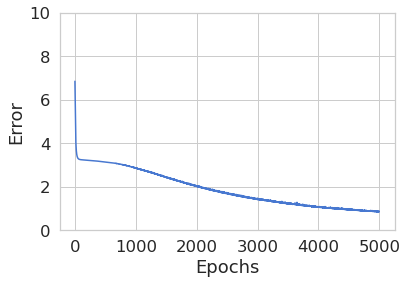

In [27]:
plot_error(classifier, 10)

## 5 - Making predictions

Accuracy on the train set must be >0.95, on the test set - >0.86

In [28]:
pred_train = classifier.predict(train_set_x)
pred_test = classifier.predict(test_set_x)

print('train set accuracy: ', accuracy(pred_train, train_set_y))
print('test set accuracy: ', accuracy(pred_test, test_set_y))

train set accuracy:  0.9506
test set accuracy:  0.8671818181818182


Now we can check our classifier on single example:

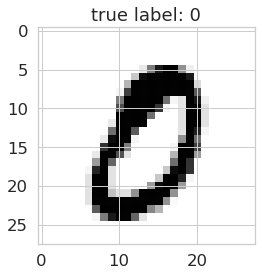

In [29]:
plot_digit(test_set_x, test_set_y, idx=6)

In [30]:
pred_single = classifier.predict(test_set_x.T[6].reshape(784, 1))
print("The digit is " + str(pred_single[0]))

The digit is 0


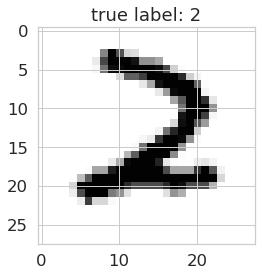

In [31]:
plot_digit(test_set_x, test_set_y, idx=90)

In [32]:
pred_single = classifier.predict(test_set_x.T[90].reshape(784, 1))
print("The digit is " + str(pred_single[0]))

The digit is 2


## 7 - Conclusion
As we can see, our model fits well the hypothesis function to the data.

#### What's next:
1. Try to experiment with different parameters to to make prediction better.
2. Compare the results you have obtained with the `sklearn.neural_network` models.
3. Try this model in the wild! Select your favorite dataset [here](https://www.kaggle.com/datasets?sortBy=hottest&group=public&page=1&pageSize=20&size=small&filetype=all&license=all&tagids=13303) and play with it.